In [24]:
%matplotlib inline
from pinn.io import load_runner
import numpy as np
from dadapy.data import Data
from numpy.random import default_rng
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from dadapy.data import Data
from numpy.random import default_rng
from glob import glob
from dadapy.plot import get_dendrogram

rng = default_rng(0)


In [2]:
def display_frame(frames, idx, cut=5, bc='black'):
    from ase import Atoms
    from ase.neighborlist import neighbor_list
    from piview import piview
    from pinn.io.runner import _frame_loader
    load_frame = _frame_loader.__wrapped__
    datum = load_frame(frames[idx[0]])

    # atoms, basic info
    atoms = Atoms(datum['elems'], positions=datum['coord'],
                  cell=datum['cell'], pbc=True)
    
    atoms.numbers[idx[1]] = 16
    i,j,d,D = neighbor_list('ijdD', atoms, cut, self_interaction=True)
    idx, pos = j[i==idx[1]], D[i==idx[1]]
    atoms = atoms[idx]
    atoms.positions = pos
    view = piview(atoms, draw_bonds=True,
                  width=150, height=150,
                  bond_cutoff=1.2, border_color=bc)
    display(view)
    
def show_center(frames, dd, idx):
    center = subsample[dd.cluster_centers[idx]]
    idx = center//640, center%640
    display_frame(frames, idx)

In [16]:
from pinn.io import load_ds
from ase.data.colors import jmol_colors
from ase.data import chemical_symbols
ds = load_ds('../datasets/pils-40ps.yml').take(100)
elems = np.concatenate([d['elems'] for d in ds])[subsample]
jmap = lambda x: 'k' if x==1 else jmol_colors[x]

In [7]:
latent = np.load(f'../latent/model1-pils-v6/latent.npy')
subsample = rng.choice(latent.shape[0], size=5000, replace=False)
latent = latent[subsample]
dd = Data(latent)
dd.compute_distances(maxk=31)
dd.compute_density_kNN(k=30)
dd.compute_clustering_ADP(Z=5)
# show_center(frames,dd,0)
# show_center(frames,dd,4)
# show_center(frames,dd,5)

32


array([12,  4,  0, ...,  0, 11,  6])

32
32
32
32


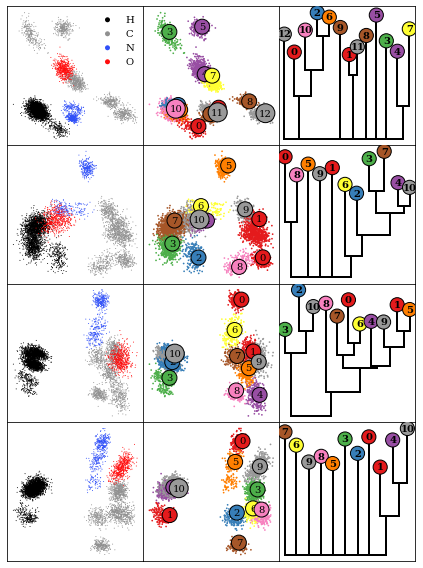

In [27]:
f, axs = plt.subplots(4,3, figsize=[6,8], gridspec_kw={'wspace':0, 'hspace':0})
v=1
for seed in [1,2,3,4]:
    ax = axs[seed-1,0]
    if seed==4:
        latent = [
            np.load(fname)[subsample] for fname in 
            glob(f'../latent/model*-pils-v6/latent.npy')]
        latent = np.mean(latent, axis=0)
    else:
        latent = np.load(f'../latent/model{seed}-pils-v6/latent.npy')[subsample]
    pca = PCA(n_components=2)
    xy = pca.fit_transform(latent)
    for elem in [1,6,7,8]:
        idx = (elems == elem)
        ax.set_xticks([]); ax.set_yticks([]); 
        ax.scatter(xy[idx,0], xy[idx,1], color=jmap(elem), ec='none', s=1, label=chemical_symbols[elem])
        
    ax = axs[seed-1,1]
    dd = Data(latent)
    dd.compute_distances(maxk=31)
    dd.compute_density_kNN(k=30)
    dd.compute_clustering_ADP(Z=5)
    cmap = plt.get_cmap('Set1', len(dd.cluster_indices))
    ax.scatter(xy[:,0], xy[:,1], c=cmap(dd.cluster_assignment), ec='none', s=3)
    ax.set_xticks([]); ax.set_yticks([]); 
    for i, cc in enumerate(dd.cluster_centers):
        ax.text(xy[cc,0], xy[cc,1], i,  bbox = dict(boxstyle="circle", fc=cmap(i)))
    
    ax =axs[seed-1,2]
    plt.sca(axs[seed-1,2])
    get_dendrogram(dd, cmap='Set1')
    ax.set_xticks([]); ax.set_yticks([]); 
    ax.set_xlabel(None); ax.set_ylabel(None); 
axs[0,0].legend()
plt.tight_layout()
axs[0,0].legend(markerscale=5)
plt.savefig('adam_clustering.png')

In [26]:
def get_dendrogram(Data, cmap="viridis", savefig="", logscale=True):
    """Generate a visualisation of the topography computed with ADP.

    This visualisation fundamentally corresponds to a hierarchy of the clusters built
    with Single Linkage taking as similarity measure the density at the
    border between clusters.
    At difference from classical dendrograms, where all the branches have the same height,
    in this case the height of the branches is proportional to the density of the cluster
    centre.
    To convey more information, the distance in the x-axis between
    clusters is proportional to the population (or its logarithm).

    Args:
        Data: A dadapy data object for which ADP has been already run.
        cmap: (optional) The color map for representing the different clusters,
            the default is "viridis".
        savefig: (str, optional) A string with the name of the file in which the dendrogram
            will be saved. The default is empty, so no file is generated.
        logscale: (bool, optional) Makes the distances in the x-axis between clusters proportional
            to the logarithm of the population of the clusters instead of
            proportional to the population itself. In very unbalanced clusterings,
            it makes the dendrogram more human readable. The default is True.

    Returns:

    """
    from matplotlib import cm
    # Prepare some auxiliary lists
    e1 = []
    e2 = []
    d12 = []
    L = []
    Li1 = []
    Li2 = []
    Ldis = []
    Fmax = max(Data.log_den)
    Rho_bord_m = np.copy(Data.log_den_bord)
    # Obtain populations of the clusters for fine tunning the x-axis
    pop = np.zeros((Data.N_clusters), dtype=int)
    for i in range(Data.N_clusters):
        pop[i] = len(Data.cluster_indices[i])
        if logscale:
            pop[i] = np.log(pop[i])
    xr = np.sum(pop)
    # Obtain distances in list format from topography
    for i in range(Data.N_clusters - 1):
        for j in range(i + 1, Data.N_clusters):
            dis12 = Fmax - Rho_bord_m[i][j]
            e1.append(i)
            e2.append(j)
            d12.append(dis12)

    # Obtain the dendrogram in form of links
    nlinks = 0
    clnew = Data.N_clusters
    for j in range(Data.N_clusters - 1):
        aa = np.argmin(d12)
        nlinks = nlinks + 1
        L.append(clnew + nlinks)
        Li1.append(e1[aa])
        Li2.append(e2[aa])
        Ldis.append(d12[aa])
        # update distance matrix
        t = 0
        fe = Li1[nlinks - 1]
        fs = Li2[nlinks - 1]
        newname = L[nlinks - 1]
        # list of untouched clusters
        unt = []
        for _ in d12:
            if (e1[t] != fe) & (e1[t] != fs):
                unt.append(e1[t])
            if (e2[t] != fe) & (e2[t] != fs):
                unt.append(e2[t])
            t = t + 1
        myset = set(unt)
        unt = list(myset)
        # Build a new distance matrix
        e1new = []
        e2new = []
        d12new = []
        for j in unt:
            t = 0
            dmin = 9.9e99
            for _ in d12:
                if (e1[t] == j) | (e2[t] == j):
                    if (e1[t] == fe) | (e2[t] == fe) | (e1[t] == fs) | (e2[t] == fs):
                        if d12[t] < dmin:
                            dmin = d12[t]
                t = t + 1
            e1new.append(j)
            e2new.append(newname)
            d12new.append(dmin)

        t = 0
        for _ in d12:
            if (unt.count(e1[t])) & (unt.count(e2[t])):
                e1new.append(e1[t])
                e2new.append(e2[t])
                d12new.append(d12[t])
            t = t + 1

        e1 = e1new
        e2 = e2new
        d12 = d12new

    # Get the order in which the elements should be displayed
    sorted_elements = []
    sorted_elements.append(L[nlinks - 1])

    for jj in range(len(L)):
        j = len(L) - jj - 1
        for i in range(len(sorted_elements)):
            if sorted_elements[i] == L[j]:
                sorted_elements[i] = Li2[j]
                sorted_elements.insert(i, Li1[j])

    add = 0.0
    x = []
    y = []
    label = []
    join_distance = []
    for i in range(len(sorted_elements)):
        label.append(sorted_elements[i])
        j = Data.cluster_centers[label[i]]
        y.append(Data.log_den[j])
        x.append(add + 0.5 * pop[sorted_elements[i]])
        add = add + pop[sorted_elements[i]]
        join_distance.append(add)

    xs = x.copy()
    ys = y.copy()
    labels = label.copy()
    zorder = 0
    for jj in range(len(L)):
        c1 = label.index(Li1[jj])
        c2 = label.index(Li2[jj])
        label.append(L[jj])
        if c1 < len(sorted_elements):
            x.append(join_distance[c1])
        else:
            x.append((x[c1] + x[c2]) / 2.0)
        ynew = Fmax - Ldis[jj]
        y.append(ynew)
        x1 = x[c1]
        y1 = y[c1]
        x2 = x[c2]
        y2 = y[c2]
        zorder = zorder + 1
        plt.plot(
            [x1, x1], [y1, ynew], color="k", linestyle="-", linewidth=2, zorder=zorder
        )
        zorder = zorder + 1
        plt.plot(
            [x2, x2], [y2, ynew], color="k", linestyle="-", linewidth=2, zorder=zorder
        )
        zorder = zorder + 1
        plt.plot(
            [x1, x2], [ynew, ynew], color="k", linestyle="-", linewidth=2, zorder=zorder
        )

    zorder = zorder + 1
    cmal = cm.get_cmap(cmap, Data.N_clusters)
    colors = cmal(np.arange(0, cmal.N))
    plt.scatter(xs, ys, c=labels, s=200, zorder=zorder, cmap=cmap, ec='k')
    for i in range(Data.N_clusters):
        zorder = zorder + 1
        cc = "k"
        r = colors[labels[i]][0]
        g = colors[labels[i]][1]
        b = colors[labels[i]][2]
        luma = (0.2126 * r + 0.7152 * g + 0.0722 * b) * 255
        if luma < 156:
            cc = "k"
        plt.annotate(
            labels[i],
            (xs[i], ys[i]),
            horizontalalignment="center",
            verticalalignment="center",
            zorder=zorder,
            c=cc,
            weight="bold",
        )
    plt.xlim([-0.02 * xr, xr])
    xname = "Population"
    if logscale:
        xname = "ln(Population)"
        plt.xlim([0, xr])
    plt.xlabel(xname)
    plt.ylabel(r"ln($\rho$)")